# tsfreshを使って特徴量を生成するサンプル

## tsfreshのインストール
pipを使って最新のtsfreshをインストールします。

In [9]:
!pip install wfdb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (ja_JP.UTF-8)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 7.4 MB/s eta 0:00:00


## ライブラリのインポート

In [10]:
import os 
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsfresh.feature_extraction import (
    MinimalFCParameters,
    extract_features,
    feature_calculators,
)

import wfdb

## データの読み込み

In [11]:

dataset_root = './dataset'
download_dir = os.path.join(dataset_root, 'download')

wfdb.dl_database('mitdb', dl_dir=download_dir)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [12]:
class BaseECGDatasetPreprocessor(object):

    def __init__(
            self,
            dataset_root,
            window_size=720,  # 2 seconds
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        # split list
        self.train_record_list = [
            '101', '106', '108', '109', '112', '115', '116', '118', '119', '122',
            '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230'
        ]
        self.test_record_list = [
            '100', '103', '105', '111', '113', '117', '121', '123', '200', '210',
            '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234'
        ]
        # annotation
        self.labels = ['N', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'V': 'V', 'E': 'V'
        }

    def _load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        # read dat file
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate
        # read annotation file
        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def _normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':
            # Min-Max scaling
            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':
            # Zero mean and unit variance
            signal = (signal - np.mean(signal)) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid method: {}".format(method))

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def preprocess_dataset(
            self,
            normalize=True
    ):
        # preprocess training dataset
        self._preprocess_dataset_core(self.train_record_list, "train", normalize)
        # preprocess test dataset
        self._preprocess_dataset_core(self.test_record_list, "test", normalize)

    def _preprocess_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        Xs, ys = [], []
        save_dir = os.path.join(self.dataset_root, 'preprocessed', mode)
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, "X.npy"), np.vstack(Xs))
        np.save(os.path.join(save_dir, "y.npy"), np.concatenate(ys))


In [ ]:
BaseECGDatasetPreprocessor(dataset_root).preprocess_dataset()

In [212]:
X_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'y.npy'))

## データの切り出し  
tsfreshに合わせてDataFrame化する

In [213]:
N_train = 200
N_test = 200

In [214]:
train_start = 3450
train_df = pd.DataFrame(X_train[train_start:train_start+N_train,:].flatten(), columns=['data'])
train_df['id'] = np.array([[i] * X_train.shape[1] for i in range(N_train)]).flatten()

#train_y = np.array([[y_train[train_start+i]] * X_train.shape[1] for i in range(N_train)]).flatten()
train_y = y_train[train_start:train_start + N_train]


test_start = 32000
test_df = pd.DataFrame(X_test[test_start:test_start+N_test,:].flatten(), columns=['data'])
test_df['id'] = np.array([[i] * X_test.shape[1] for i in range(N_test)]).flatten()

test_y = np.array([[y_test[test_start+i]] * X_test.shape[1] for i in range(N_test)]).flatten()
test_y = y_test[test_start:test_start + N_test]



## 特徴量の生成

ここからエンジン回転数から特徴量を作ることを考えてみます。  
一例として回転数の平均や標準偏差を特徴量にしたい場合は、例えば以下のようなコードで特徴量を作ることができます。  
（pandasの使い方については[こちら](https://github.com/The-Japan-DataScientist-Society/100knocks-preprocess)が参考になります！）

In [215]:
train_x = train_df.groupby('id')['data'].agg(['mean','std']).reset_index(drop=False)
train_x.head()

,id,mean,std
0,0,0.436009,1.060203
1,1,0.288539,1.044557
2,2,0.381217,1.063246
3,3,0.389670,1.062465
4,4,0.166296,1.052902


より多種の特徴量を生成したい場合には自分で関数を作成しなければならず、いろいろな特徴量を試したいと思っても時間がかかってしまいます。  
tsfreshはこのような場合に使用すると便利な関数で、たくさんの特徴量を自動的に生成してくれます。  
実際にtsfreshを使って特徴量を生成してみます。

In [216]:
features.head()

,data__sum_values,data__median,data__mean,data__length,data__standard_deviation,data__variance,data__root_mean_square,data__maximum,data__absolute_maximum,data__minimum,data__ar_coefficient__coeff_0__k_4,data__ar_coefficient__coeff_1__k_4,data__ar_coefficient__coeff_2__k_4,data__ar_coefficient__coeff_3__k_4
0,313.926564,0.102787,0.436009,720.0,1.059466,1.122469,1.145676,5.903466,5.903466,-1.486626,0.012049,2.461247,-2.360962,1.080477
1,207.748332,-0.005891,0.288539,720.0,1.043832,1.089585,1.082977,5.903466,5.903466,-1.296440,0.008685,2.436295,-2.265710,0.974055
2,274.476514,0.143541,0.381217,720.0,1.062507,1.128922,1.128826,5.903466,5.903466,-1.296440,0.012190,2.493041,-2.458683,1.200243
3,280.562472,0.170711,0.389670,720.0,1.061727,1.127264,1.130976,5.889881,5.889881,-1.649643,0.011247,2.525157,-2.554977,1.309415
4,119.732881,-0.141738,0.166296,720.0,1.052171,1.107063,1.065231,5.631771,5.631771,-2.111524,0.004314,2.489156,-2.455834,1.213764


In [217]:
len(features.columns)

14

デフォルトでは789個の特徴量が生成されました。  
生成する特徴量は指定することができますが、あらかじめ決められた特徴量のセットを指定することもできます。

In [218]:
settings = MinimalFCParameters()

features = extract_features(
        train_df,
        column_id="id",
        default_fc_parameters=settings,
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 100/100 [00:00<00:00, 779.77it/s]


In [219]:
features.head()

,data__sum_values,data__median,data__mean,data__length,data__standard_deviation,data__variance,data__root_mean_square,data__maximum,data__absolute_maximum,data__minimum
0,313.926564,0.102787,0.436009,720.0,1.059466,1.122469,1.145676,5.903466,5.903466,-1.486626
1,207.748332,-0.005891,0.288539,720.0,1.043832,1.089585,1.082977,5.903466,5.903466,-1.296440
2,274.476514,0.143541,0.381217,720.0,1.062507,1.128922,1.128826,5.903466,5.903466,-1.296440
3,280.562472,0.170711,0.389670,720.0,1.061727,1.127264,1.130976,5.889881,5.889881,-1.649643
4,119.732881,-0.141738,0.166296,720.0,1.052171,1.107063,1.065231,5.631771,5.631771,-2.111524


In [220]:
len(features.columns)

10

`MinimalFCParameters`では平均や中央値など基本的な特徴量が10個の特徴量が生成されました。 
どの特徴量を生成するかは`default_fc_parameters`に渡される`dict`で定義されており、`MinimalFCParameters`で得られる変数（ここでは`settings`）では以下のような感じになっています。

In [221]:
settings

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

また、他の特徴量を追加する場合は以下のように`settings`に項目を追加します。どのような特徴量が用意されているかは[公式ドキュメント](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)を参照ください。

In [222]:
# 4次のARモデルの係数を特徴量として追加する
settings["ar_coefficient"] = [
    {"coeff": 0, "k": 4},
    {"coeff": 1, "k": 4},
    {"coeff": 2, "k": 4},
    {"coeff": 3, "k": 4},
]

features = extract_features(
        train_df,
        column_id="id",
        default_fc_parameters=settings,
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 100/100 [00:00<00:00, 703.39it/s]


In [223]:
features.head()

,data__sum_values,data__median,data__mean,data__length,data__standard_deviation,data__variance,data__root_mean_square,data__maximum,data__absolute_maximum,data__minimum,data__ar_coefficient__coeff_0__k_4,data__ar_coefficient__coeff_1__k_4,data__ar_coefficient__coeff_2__k_4,data__ar_coefficient__coeff_3__k_4
0,313.926564,0.102787,0.436009,720.0,1.059466,1.122469,1.145676,5.903466,5.903466,-1.486626,0.012049,2.461247,-2.360962,1.080477
1,207.748332,-0.005891,0.288539,720.0,1.043832,1.089585,1.082977,5.903466,5.903466,-1.296440,0.008685,2.436295,-2.265710,0.974055
2,274.476514,0.143541,0.381217,720.0,1.062507,1.128922,1.128826,5.903466,5.903466,-1.296440,0.012190,2.493041,-2.458683,1.200243
3,280.562472,0.170711,0.389670,720.0,1.061727,1.127264,1.130976,5.889881,5.889881,-1.649643,0.011247,2.525157,-2.554977,1.309415
4,119.732881,-0.141738,0.166296,720.0,1.052171,1.107063,1.065231,5.631771,5.631771,-2.111524,0.004314,2.489156,-2.455834,1.213764


さらに4つの特徴量が追加されました。  
このほか、独自の特徴量も生成できますのでその方法は[公式ドキュメント](https://tsfresh.readthedocs.io/en/latest/)や[記事](https://qiita.com/niwashing/items/c5e75c80256ffb2e0dd7)を参照ください。

## 学習
以上のように生成した特徴量で適当に学習モデルを生成し、予測をしてみます。

In [224]:
test_x = extract_features(
        test_df,
        column_id="id",
        default_fc_parameters=settings,
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 100/100 [00:00<00:00, 650.04it/s]


In [225]:
len(test_x.columns)

14

In [226]:
features

,data__sum_values,data__median,data__mean,data__length,data__standard_deviation,data__variance,data__root_mean_square,data__maximum,data__absolute_maximum,data__minimum,data__ar_coefficient__coeff_0__k_4,data__ar_coefficient__coeff_1__k_4,data__ar_coefficient__coeff_2__k_4,data__ar_coefficient__coeff_3__k_4
0,313.926564,0.102787,0.436009,720.0,1.059466,1.122469,1.145676,5.903466,5.903466,-1.486626,0.012049,2.461247,-2.360962,1.080477
1,207.748332,-0.005891,0.288539,720.0,1.043832,1.089585,1.082977,5.903466,5.903466,-1.296440,0.008685,2.436295,-2.265710,0.974055
2,274.476514,0.143541,0.381217,720.0,1.062507,1.128922,1.128826,5.903466,5.903466,-1.296440,0.012190,2.493041,-2.458683,1.200243
3,280.562472,0.170711,0.389670,720.0,1.061727,1.127264,1.130976,5.889881,5.889881,-1.649643,0.011247,2.525157,-2.554977,1.309415
4,119.732881,-0.141738,0.166296,720.0,1.052171,1.107063,1.065231,5.631771,5.631771,-2.111524,0.004314,2.489156,-2.455834,1.213764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,67.975068,-0.100984,0.094410,720.0,0.568138,0.322780,0.575928,3.077842,3.077842,-0.413433,0.001444,1.638852,-0.481559,-0.284689
196,104.653833,-0.073814,0.145353,720.0,0.584429,0.341557,0.602233,3.118597,3.118597,-0.413433,0.001720,1.699903,-0.599977,-0.209045
197,91.897774,-0.087399,0.127636,720.0,0.587449,0.345097,0.601155,3.254444,3.254444,-0.413433,0.001321,1.741466,-0.636373,-0.297132
198,144.334823,-0.005891,0.200465,720.0,0.612163,0.374744,0.644150,3.240859,3.240859,-0.413433,0.001694,1.706670,-0.574031,-0.326429


In [227]:
# 学習データから適当に評価用のデータを分ける（交差検証はしない）
n=50
x_train = np.array(features[:n])
y_train = np.array(train_y[:n])
x_valid = np.array(features[n:])
y_valid = np.array(train_y[n:])

パラメータは適当に設定

In [252]:
params = {#'lambda_l1': 2.9923049684572518e-05,
 #'lambda_l2': 0.29561270408123375,
 #'num_leaves': 177,
 #'feature_fraction': 0.6798845602678106,
 #'bagging_fraction': 0.7326602610581225,
 #'bagging_freq': 9,
 #'min_child_samples': 32,
 'learning_rate': 0.001,
 #'num_class': 6,
 'objective': 'binary',
}


In [253]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_valid = lgb.Dataset(x_valid, y_valid, free_raw_data=False, reference=lgb_train)

In [254]:
y_train.shape

(50,)

In [257]:
evaluation_results = {}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_valid,
    callbacks=[
        lgb.early_stopping(10),
        lgb.record_evaluation(evaluation_results)
    ]
)

[LightGBM] [Info] Number of positive: 18, number of negative: 32
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.360000 -> initscore=-0.575364
[LightGBM] [Info] Start training from score -0.575364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

lossをプロットし確認

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('binary_logloss', 0.7031445900587939)])})

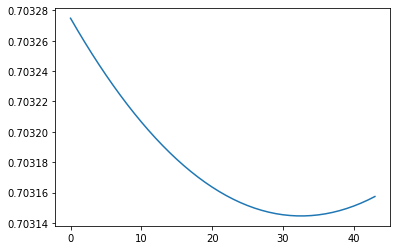

In [258]:
plt.plot(evaluation_results["valid_0"]["binary_logloss"])
model.best_score

In [259]:
pred = model.predict(test_x)
# 確率をラベルにする
pred_fail = [np.argmax(p) for p in pred]

In [260]:
pred_df = pd.DataFrame(np.c_[test_df.id.unique(),pred_fail], columns=['id', 'fail_type'])

In [261]:
pred_df.head()

,id,fail_type
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## まとめ
本サンプルでは、特徴量を自動生成するライブラリ`tsfresh`を紹介しました。初めてデータ分析に取り組まれる方は、まずはtsfreshで用意されている特徴量を使って学習し、ベースラインモデルを作ったり、特徴量の当たりをつけるといったことから初めてみるのも良いのかもしれません。